# Getting Started with FrontTracker

This notebook provides a quick introduction to **FrontTracker**.  

In this demo, we will:  
1. **Load sample data** consisting of a temperature field and a precomputed gradient magnitude (GM).  
2. **Apply a dynamic threshold** (90th percentile) to highlight strong gradients that may correspond to fronts.  
3. **Identify and track fronts** using the `FrontTracker` class.  
4. **Visualize results** with three complementary representations:  
   - *Contours* to delineate frontal zone.  
   - *Skeletons* to extract the frontal line.  
   - *Ellipses* to approximate `orientation`, `size`, and `eccentricity`.  

This notebook is intended as a **first hands-on example** to get familiar with the workflow of FrontTracker, from raw data to graphical output.  

In [1]:
# -----------------------------------
# LIBRARY IMPORTS
# -----------------------------------
import numpy as np
import xarray as xr
from datetime import datetime
from scipy.io import loadmat
import cartopy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from fronttracker.core import FrontTracker

# -----------------------------------
# LOAD DATA
# -----------------------------------
ds = xr.open_dataset(".../med-cmcc-tem-rean-d_1756055144168.nc")
thetao = ds["thetao"][0,0,:,:]

data = loadmat('.../gm.mat')
gm = data['gm'].T/4
longitude = data['longitude'].flatten()
latitude = data['latitude'].flatten()

# -----------------------------------
# FRONT THRESHOLD
# -----------------------------------
treshold = np.nanpercentile(gm.flatten(), 90)
print(f"90th percentile = {treshold:.4f}")
gm[gm < treshold] = np.nan

90th percentile = 0.0282


In [2]:
# -----------------------------------
# FRONT IDENTIFICATION AND TRACKING
# -----------------------------------

# Define a single timestamp for this demo (21 May 2025)
time = np.array([np.datetime64("2025-05-21")])

# Wrap the GM field into a 3D array with one time step
grid = np.array([gm])

# Initialize the front tracker
front_tracker = FrontTracker()

# Identify fronts in the GM field using the threshold computed earlier
front_tracker.identify_fronts(time, longitude, latitude, grid, treshold=treshold)

# Link fronts between consecutive time steps (temporal tracking)
front_tracker.track()

print("Fronts:", len(front_tracker.fronts))

Fronts: 391


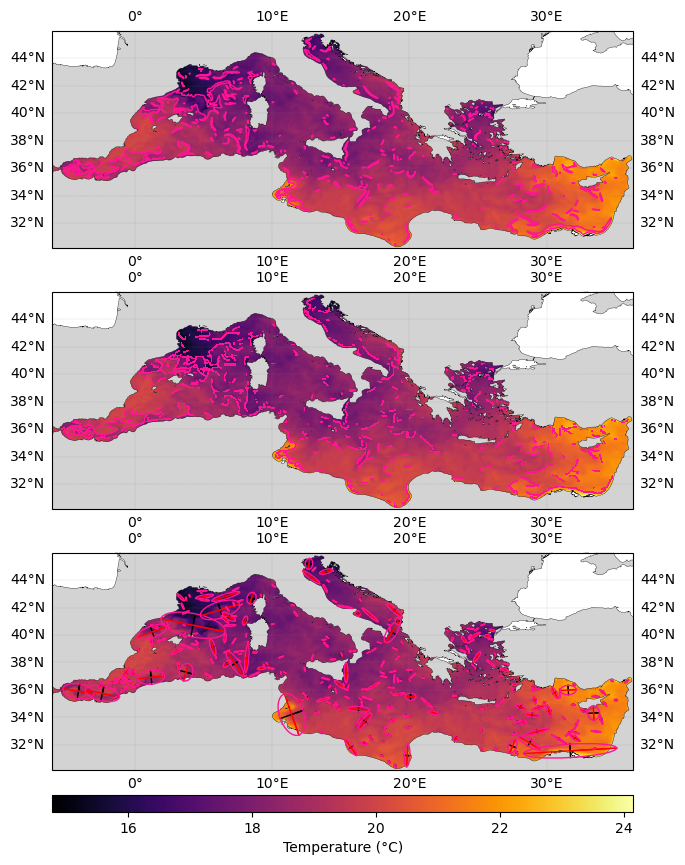

In [3]:
# -----------------------------------
# VISUALIZATION SETUP
# -----------------------------------

# Create a figure with 3 panels (rows) and PlateCarree projection
fig = plt.figure(figsize=(6.2*4, 4.8*2))
ax1 = fig.add_subplot(3, 1, 1, projection=cartopy.crs.PlateCarree())
ax2 = fig.add_subplot(3, 1, 2, projection=cartopy.crs.PlateCarree())
ax3 = fig.add_subplot(3, 1, 3, projection=cartopy.crs.PlateCarree())

for ax in [ax1, ax2, ax3]:
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale="10m", edgecolor='k', facecolor=cartopy.feature.COLORS['land'])
    ax.add_feature(land, facecolor='lightgray', linewidth=0.25)
    gl = ax.gridlines(draw_labels=True, linewidth=0.25, color='gray', alpha=0.5, linestyle='--')

# Plot the base temperature field (thetao) in all three panels
pc = ax1.pcolor(longitude, latitude, thetao, cmap="inferno")
pc = ax2.pcolor(longitude, latitude, thetao, cmap="inferno")
pc = ax3.pcolor(longitude, latitude, thetao, cmap="inferno")

# -----------------------------------
# FRONT METRICS
# -----------------------------------

# Loop over each detected front
for label in front_tracker.data_labels.labels:
    front = front_tracker.fronts[label]
    
    # --- Panel 1: frontal zone
    front.contouring()
    for poly in front.contours:
        x, y = poly.exterior.xy
        ax1.plot(x, y, linewidth=1, c="deeppink")
        
    # --- Panel 2: frontal line
    front._skeleton()
    ax2.pcolor(front.skeleton.longitude, front.skeleton.latitude, front.skeleton.skeleton, cmap=ListedColormap(['deeppink']))

    # --- Panel 3: frontal ellipse
    front.front_ellipse()
    ax3.plot([front.ellipse.centre[0]+front.ellipse.size[1]/2*np.cos(np.radians(front.ellipse.angle+90)), front.ellipse.centre[0]+front.ellipse.size[1]/2*np.cos(np.radians(front.ellipse.angle + 270))],[front.ellipse.centre[1]+front.ellipse.size[1]/2*np.sin(np.radians(front.ellipse.angle+90)), front.ellipse.centre[1]+front.ellipse.size[1]/2*np.sin(np.radians(front.ellipse.angle + 270))], "k-", linewidth=1, zorder=101)
    ax3.plot([front.ellipse.centre[0],front.ellipse.centre[0]+front.ellipse.size[1]/2*np.cos(np.radians(front.ellipse.angle + 270))],[front.ellipse.centre[1],front.ellipse.centre[1]+front.ellipse.size[1]/2*np.sin(np.radians(front.ellipse.angle + 270))], "k-", linewidth=1, zorder=101)
    ax3.plot([front.ellipse.centre[0]+front.ellipse.size[0]/2*np.cos(np.radians(front.ellipse.angle)), front.ellipse.centre[0]+front.ellipse.size[0]/2*np.cos(np.radians(front.ellipse.angle + 180))],[front.ellipse.centre[1]+front.ellipse.size[0]/2*np.sin(np.radians(front.ellipse.angle)), front.ellipse.centre[1]+front.ellipse.size[0]/2*np.sin(np.radians(front.ellipse.angle + 180))], "r-", linewidth=1, zorder=101)
    ax3.plot([front.ellipse.centre[0],front.ellipse.centre[0]+front.ellipse.size[0]/2*np.cos(np.radians(front.ellipse.angle + 180))],[front.ellipse.centre[1],front.ellipse.centre[1]+front.ellipse.size[0]/2*np.sin(np.radians(front.ellipse.angle + 180))], "r-", linewidth=1, zorder=101)
    
    e = front.ellipse.e
    if e is not None:
        e.set_edgecolor('deeppink')
        e.set_facecolor('none')
        e.set_linewidth(1)
        e.set_zorder(101)
        ax3.add_patch(e)

# Add a horizontal colorbar below the last panel
axins = inset_axes(ax, width="100%", height="7.5%", loc="lower center", borderpad=-3)
cbar = fig.colorbar(pc, cax=axins, orientation="horizontal")
cbar.set_label("Temperature (°C)")

plt.show()